In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

In [2]:
def outlier_cells(X, num_mads=5):
    outliers = ((X < np.median(X) - num_mads * median_abs_deviation(X)
                 )
                | (np.median(X) + num_mads * median_abs_deviation(X) < X))
    return outliers


# function to normalize data
def norm_cpm(X):
    # Calculate the total read counts per cells
    total_counts_per_cell = np.sum(X, axis=1)
    
    # Calculate the total read counts per million (CPM) for each sample
    total_counts_per_million = total_counts_per_cell / 1e6
    
    # Divide the count matrix by the total counts per million for each sample
    return X / total_counts_per_million[:, np.newaxis]

def norm_log(X):
    # Calculate the total counts per cell
    total_counts_cell = np.sum(X, axis=1)

    # Calculate the median of total counts
    med_total_counts = np.median(total_counts_cell)

    # Scale the total counts
    scaled_counts = (X / total_counts_cell[:, np.newaxis]) * med_total_counts

    # Logarithm transformation
    return np.log1p(scaled_counts)


# Feature selection

def binomial_deviance(X):
    # ensure that n has the correct dimensionality, needs to be treated differently if sparse counts
    n = np.sum(X, axis=1)
    n = n[:, None]
    # set up appropriate dimensionality for p
    p = np.sum(X, axis=0) / np.sum(n)
    p = p[None, :]

    holder = X / (n * p)
    holder[holder == 0] = 1
    term1 = np.sum(X * np.log(holder), axis=0)
    nx = n - X
    # same thing, second holder
    holder = nx / (n * (1 - p))
    holder[holder == 0] = 1
    term2 = np.sum(nx * np.log(holder), axis=0)
    return 2 * (term1 + term2)

# Feature selection

def highly_deviance_indices(data, num_genes):
    # compute binomial deviances on the original count matrix
    devi_data = binomial_deviance(data)
    if np.isnan(devi_data).sum() is not None:
        devi_data[np.isnan(devi_data)] = 0

    # Identify the highly deviance genes indices
    indices = np.argsort(devi_data)[::-1][:num_genes]

    return indices

def preprocess_X(X, y=None, quality_control=True):
    if (quality_control == True) & (y is not None):
        # Quality control
        total_cell_counts = X.sum(axis=1)  # total counts per cell
        # Number of expressed genes in a cell
        number_genes_by_counts = (X > 0).sum(axis=1)
        log1p_total_cells_counts = np.log1p(total_cell_counts)
        log1p_number_genes_by_counts = np.log1p(number_genes_by_counts)

        # Identify the top 20 genes
        top20_genes = np.argsort(np.array(X.sum(axis=0)).ravel())[::-1][:20]
        # Calculate the total counts in the top 20 genes for each cell
        total_counts_top20_genes = np.sum(X[:, top20_genes], axis=1)
        # Calculate the percentage of counts in the top 20 genes for each cell
        pct_counts_top20_genes = total_counts_top20_genes / total_cell_counts
        # Identify and remove poor quality cells
        cells_remove = (outlier_cells(log1p_total_cells_counts, 5)
                        | outlier_cells(log1p_number_genes_by_counts, 5)
                        | outlier_cells(pct_counts_top20_genes, 5))
        X = X[(~cells_remove), :].copy()
        y = y[~cells_remove].copy()

    # Normalization the total counts per cell
    X_norm = norm_log(X)

    # add new total genes of each cells
    # X_norm = np.column_stack((X_norm, X.sum(axis=1)))

    return (X_norm, y) if y is not None else X_norm

# Loading data

In [3]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

# convert to array
X_train = X_train.toarray()
X_train

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Data Preprocession

**Normalization data using highly deviance genes**

In [4]:
X_bd_train, X_bd_valid, y_bd_train, y_bd_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
# X normalization 
X_bd_train, y_bd_train= preprocess_X(X_bd_train, y_bd_train, quality_control=True)
X_bd_valid = preprocess_X(X_bd_valid, quality_control=False)

<AxesSubplot: ylabel='Density'>

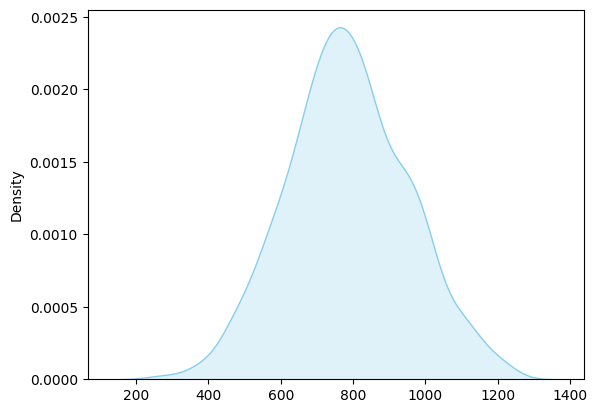

In [6]:
sns.kdeplot(X_bd_train.sum(axis=1), color='skyblue', fill=True)

**Normalization using highly variable genes**

# **Models Selection**

## Top 8000 genes

In [7]:
# select the top 8000 genes
ind_8k = highly_deviance_indices(X_train, num_genes=8000)
X_8k_train = X_bd_train[:, ind_8k]
X_8k_valid = X_bd_valid[:, ind_8k]

<AxesSubplot: ylabel='Density'>

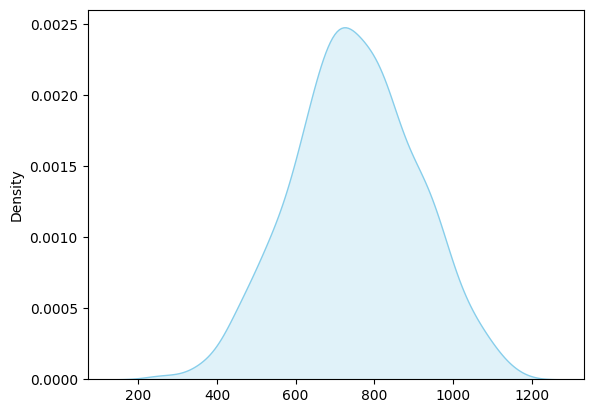

In [8]:
sns.kdeplot(X_8k_train.sum(axis=1), color='skyblue', fill=True)

**Training models**

In [19]:
# Fitting model
def training(X_train, y_train):
    # Ridge classifier
    ridge_clf = RidgeClassifier(random_state=42)
    ridge_clf.fit(X_train, y_bd_train)

    # Logistic Regression 
    logistic_clf = LogisticRegression()
    logistic_clf.fit(X_train, y_bd_train)

    # Stochastic gradient descent
    sgd_clf = SGDClassifier(random_state=42)
    sgd_clf.fit(X_train, y_bd_train)

    # Decision tree
    decision_clf = DecisionTreeClassifier(random_state=42)
    decision_clf.fit(X_train, y_train)

    # Bagging
    bagging_clf = BaggingClassifier(random_state=42)
    bagging_clf.fit(X_train, y_train)

    # Random forest
    forest_clf = RandomForestClassifier(random_state=42)
    forest_clf.fit(X_train, y_train)

    # Extra Trees
    xrf_clf = ExtraTreesClassifier(random_state=42)
    xrf_clf.fit(X_train, y_train)

    # Gradient Boosting
    gb_clf = GradientBoostingClassifier(max_features="sqrt")
    gb_clf.fit(X_train, y_train)

    # # AdaBoost
    ada_clf = AdaBoostClassifier(random_state=42)
    ada_clf.fit(X_train, y_train)

    # KNN
    knn_clf = KNeighborsClassifier()
    knn_clf.fit(X_train, y_train)

    # Naive bayes
    gaussian_clf = GaussianNB()
    gaussian_clf.fit(X_train, y_train)

    # SVM
    svm_clf = SVC()
    svm_clf.fit(X_train, y_train)

    # OneVsRestClassifier
    OneVRest_clf = OneVsRestClassifier(SVC())
    OneVRest_clf.fit(X_train, y_train)

    # OneVsOneClassifier
    OneVOne_clf = OneVsOneClassifier(SVC())
    OneVOne_clf.fit(X_train, y_train)

    # Multi-layer Perceptron classifier
    mlp_clf = MLPClassifier(random_state=42)
    mlp_clf.fit(X_train, y_train)

    # LightGBM
    lgbm = LGBMClassifier(learning_rate=0.5, verbose=-100, n_jobs=-1)
    lgbm.fit(X_train, y_train)

    models= [('Ridge', ridge_clf), ('Logistic', logistic_clf), ('SGD', sgd_clf),
         ('Decision Tree', decision_clf), ('Bagging', bagging_clf), ('Random Forest', forest_clf),
         ('Extra Trees', xrf_clf), ('AdaBoost', ada_clf), ('Gradient Boosting', gb_clf),
         ('KNN', knn_clf), ('Naive Bayes', gaussian_clf), ('SVM', svm_clf), 
         ('One vs the rest', OneVRest_clf), ('One vs one', OneVOne_clf),  
         ('Multi-layer Perceptron', mlp_clf), ('Light GBM', lgbm)
        ]
    
    return models

**Fitting model**

In [20]:
models = training(X_8k_train, y_bd_train)

In [38]:
score_dict = dict()
for i, model in models:
    predictions = model.predict(X_8k_valid)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, X_8k_train, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  Ridge is:  0.844049043062201
Cross Validation Score of  Ridge is :  0.8218686936661117
------------------------------------------------------------
Balanced score of  Logistic is:  0.8392643540669857
Cross Validation Score of  Logistic is :  0.8324334259289572
------------------------------------------------------------
Balanced score of  SGD is:  0.8511014752791068
Cross Validation Score of  SGD is :  0.8396313817118187
------------------------------------------------------------
Balanced score of  Decision Tree is:  0.6549968671679197
Cross Validation Score of  Decision Tree is :  0.7146625293844757
------------------------------------------------------------
Balanced score of  Bagging is:  0.6922455285942128
Cross Validation Score of  Bagging is :  0.775326974780798
------------------------------------------------------------
Balanced score of  Random Forest is:  0.6716507177033493
Cross Validation Score of  Random Forest is :  0.6957791491306884
-----------------

Text(0.5, 1.0, 'Accuracy Classifier Comparison among models in 5-Fold cross validation with top 8000 genes')

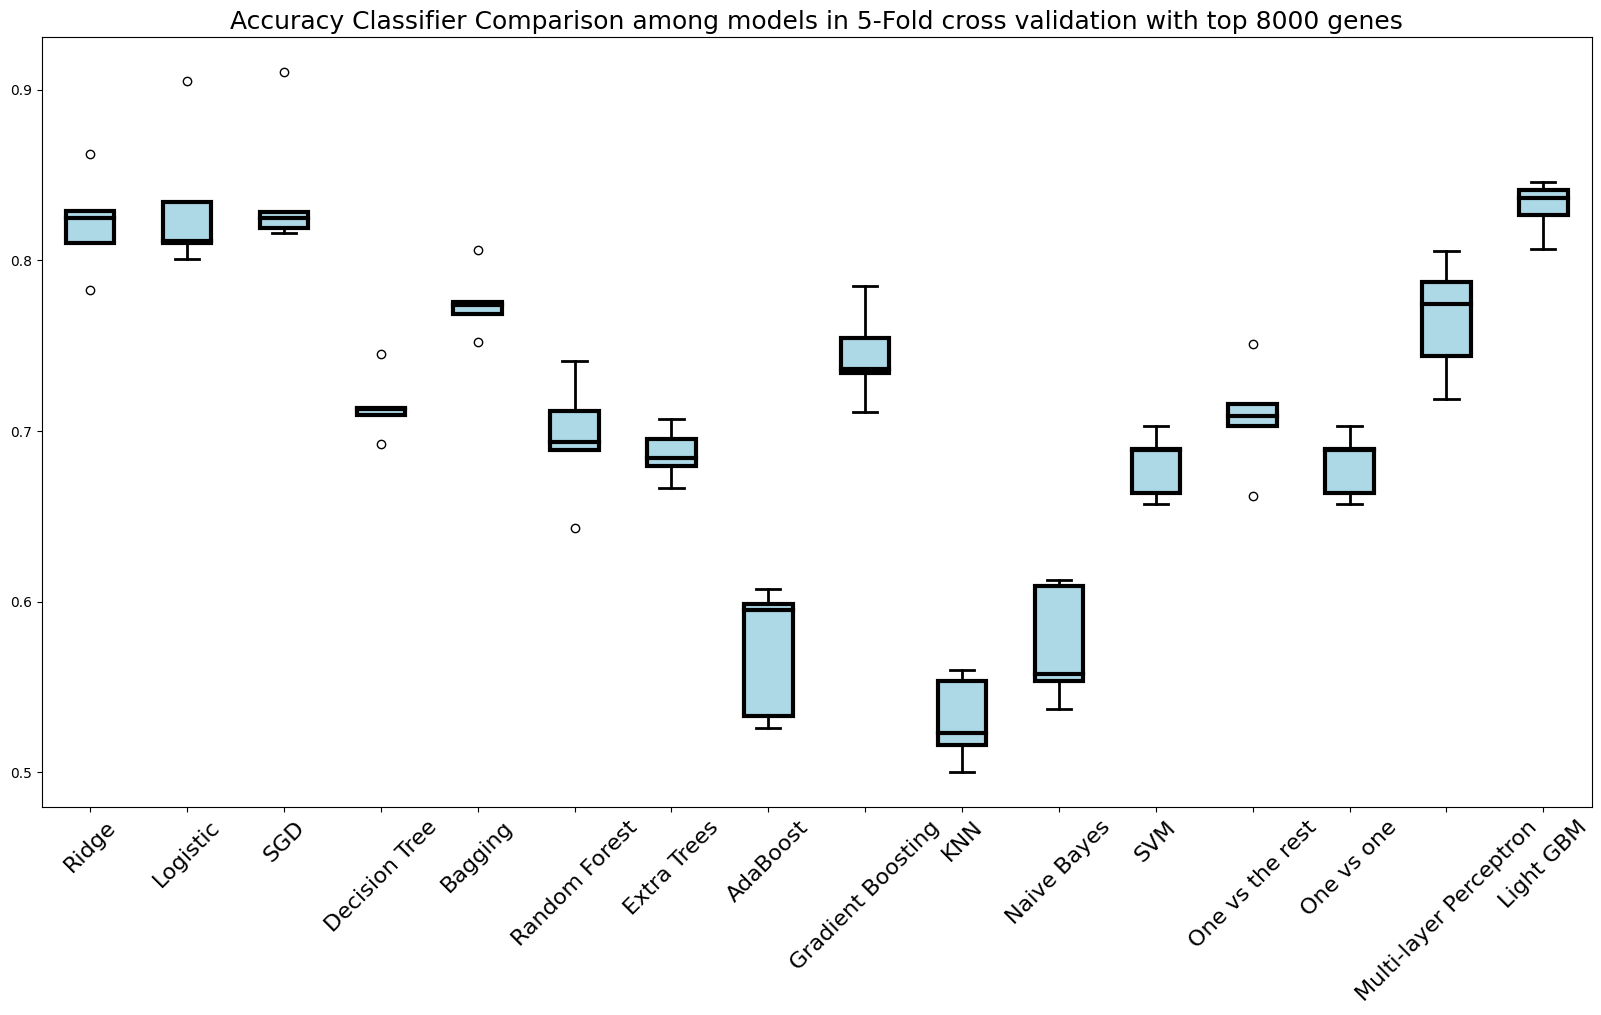

In [39]:
# Draw boxplot 
label = list(score_dict.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among models in 5-Fold cross validation with top 8000 genes", fontsize=18)

Regarding the boxplots, we can see several models that have potential in classification: LightGBM, Logistic Regression, SGD, MLP, Ridge, Gradient Boosting, and Bagging.

**With scale data**

In [53]:
scaler = StandardScaler()
X_8k_train_scale = scaler.fit_transform(X_8k_train)
X_8k_valid_scale = scaler.fit_transform(X_8k_valid)
models_scale = training(X_8k_train_scale, y_bd_train)

score_dict = dict()
for i, model in models:
    predictions = model.predict(X_8k_valid_scale)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, X_8k_train_scale, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  Ridge is:  0.8148425039872408
Cross Validation Score of  Ridge is :  0.7589026590019639
------------------------------------------------------------
Balanced score of  Logistic is:  0.8617922647527911
Cross Validation Score of  Logistic is :  0.7331299393613196
------------------------------------------------------------
Balanced score of  SGD is:  0.835302033492823
Cross Validation Score of  SGD is :  0.7628418598875402
------------------------------------------------------------
Balanced score of  Decision Tree is:  0.4439507860560492
Cross Validation Score of  Decision Tree is :  0.7146625293844757
------------------------------------------------------------
Balanced score of  Bagging is:  0.38210583276372745
Cross Validation Score of  Bagging is :  0.775326974780798
------------------------------------------------------------
Balanced score of  Random Forest is:  0.618545653907496
Cross Validation Score of  Random Forest is :  0.6957791491306884
-----------------

Text(0.5, 1.0, 'Accuracy Classifier Comparison among models in 5-Fold cross validation')

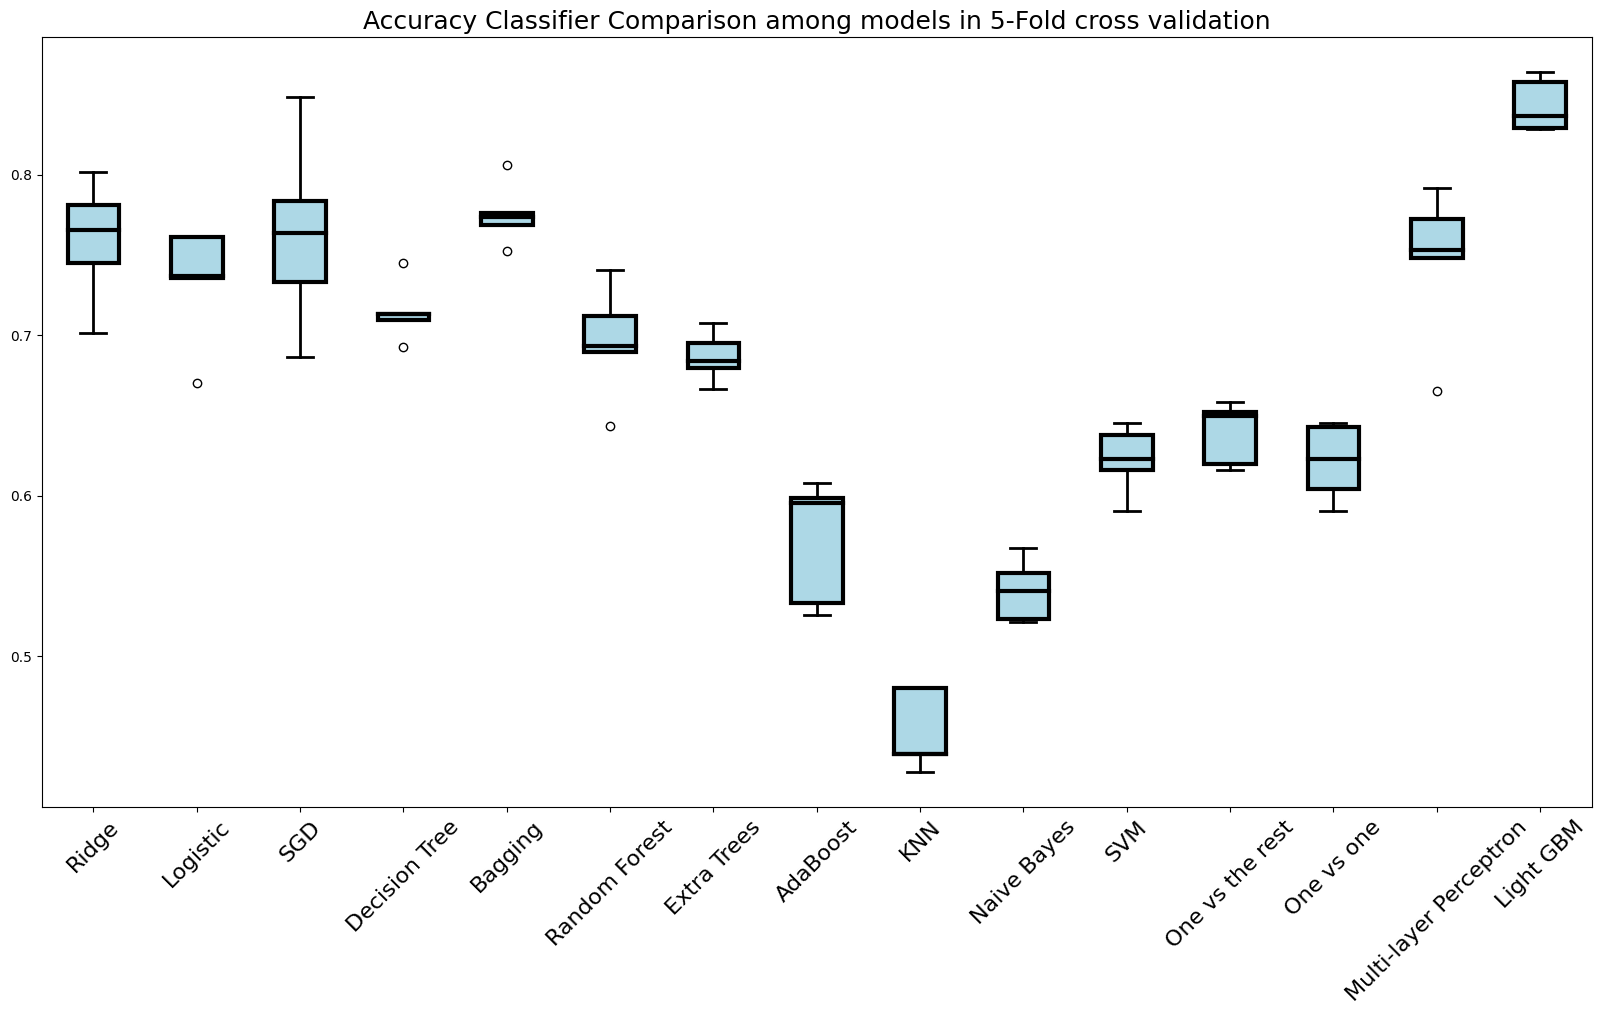

In [54]:
# Draw boxplot 
label = list(score_dict.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among scale models_8k in 5-Fold cross validation", fontsize=18)

Regarding the boxplots, we can see several models with scale data that have potential in classification: LGBM

## Top 4000 genes

In [23]:
# select the top 4000 genes
ind_4k = highly_deviance_indices(X_train, num_genes=4000)
X_4k_train = X_bd_train[:, ind_4k]
X_4k_valid = X_bd_valid[:, ind_4k]

In [24]:
models_4k = training(X_4k_train, y_bd_train)

In [25]:
score_4k_dict = dict()
for i, model in models_4k:
    predictions = model.predict(X_4k_valid)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, X_4k_train, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_4k_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  Ridge is:  0.8498056220095694
Cross Validation Score of  Ridge is :  0.8240924133426615
------------------------------------------------------------
Balanced score of  Logistic is:  0.8715111642743222
Cross Validation Score of  Logistic is :  0.8201840575475133
------------------------------------------------------------
Balanced score of  SGD is:  0.8463167862838915
Cross Validation Score of  SGD is :  0.8613592520245946
------------------------------------------------------------
Balanced score of  Decision Tree is:  0.6481829573934837
Cross Validation Score of  Decision Tree is :  0.7112682539693462
------------------------------------------------------------
Balanced score of  Bagging is:  0.6785643084985191
Cross Validation Score of  Bagging is :  0.7618266612804845
------------------------------------------------------------
Balanced score of  Random Forest is:  0.7132675438596492
Cross Validation Score of  Random Forest is :  0.6988630461818147
---------------

Text(0.5, 1.0, 'Accuracy Classifier Comparison among models in 5-Fold cross validation with top 4000 genes')

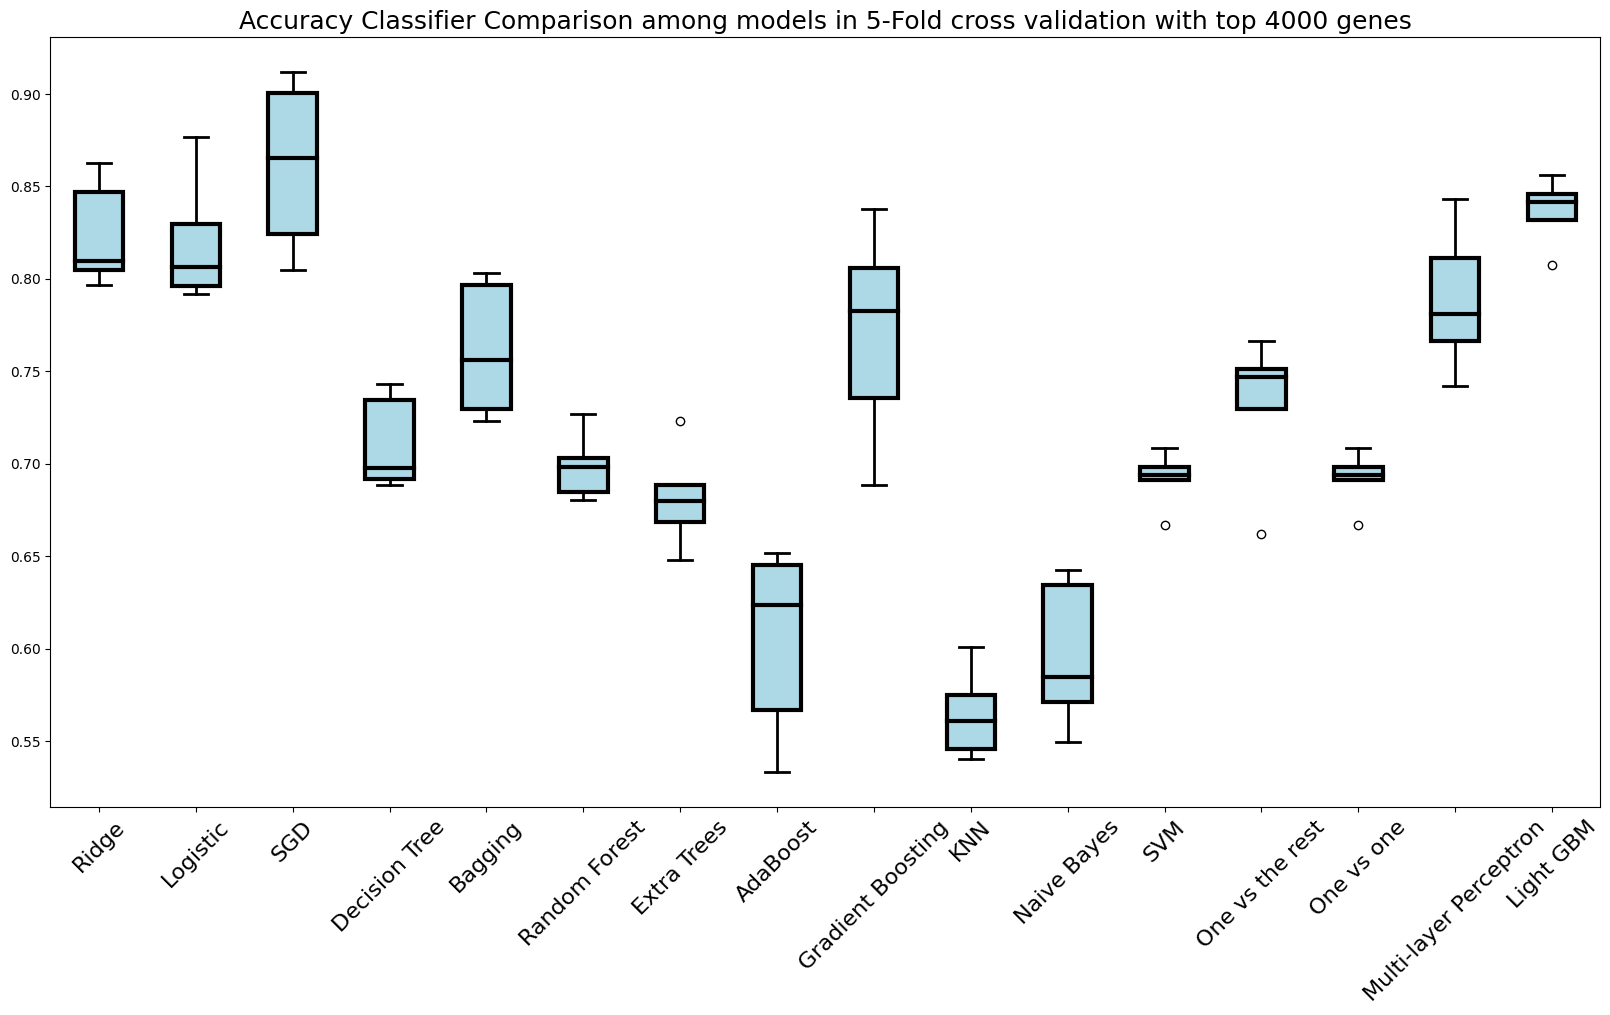

In [40]:
# Draw boxplot 
label = list(score_4k_dict.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_4k_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among models in 5-Fold cross validation with top 4000 genes", fontsize=18)

Regarding the boxplots, we can see several models that have potential in classification: Ridge, logistic, SGD, MLP, LGBM

**With scale data**

In [76]:
scaler = StandardScaler()
X_4k_train_scale = scaler.fit_transform(X_4k_train)
X_4k_valid_scale = scaler.fit_transform(X_4k_valid)
models_4k_scale = training(X_4k_train_scale, y_bd_train)

score_4k_dict = dict()
for i, model in models_4k_scale:
    predictions = model.predict(X_4k_valid_scale)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, X_4k_train_scale, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_4k_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  Ridge is:  0.8066935805422648
Cross Validation Score of  Ridge is :  0.7983160408681759
------------------------------------------------------------
Balanced score of  Logistic is:  0.8034041068580543
Cross Validation Score of  Logistic is :  0.786821932204256
------------------------------------------------------------
Balanced score of  SGD is:  0.7844647129186603
Cross Validation Score of  SGD is :  0.8184394880273729
------------------------------------------------------------
Balanced score of  Decision Tree is:  0.6373177261335157
Cross Validation Score of  Decision Tree is :  0.7112682539693462
------------------------------------------------------------
Balanced score of  Bagging is:  0.6942142287537024
Cross Validation Score of  Bagging is :  0.7618266612804845
------------------------------------------------------------
Balanced score of  Random Forest is:  0.7099780701754386
Cross Validation Score of  Random Forest is :  0.6988630461818147
----------------

Text(0.5, 1.0, 'Accuracy Classifier Comparison among models in 5-Fold cross validation')

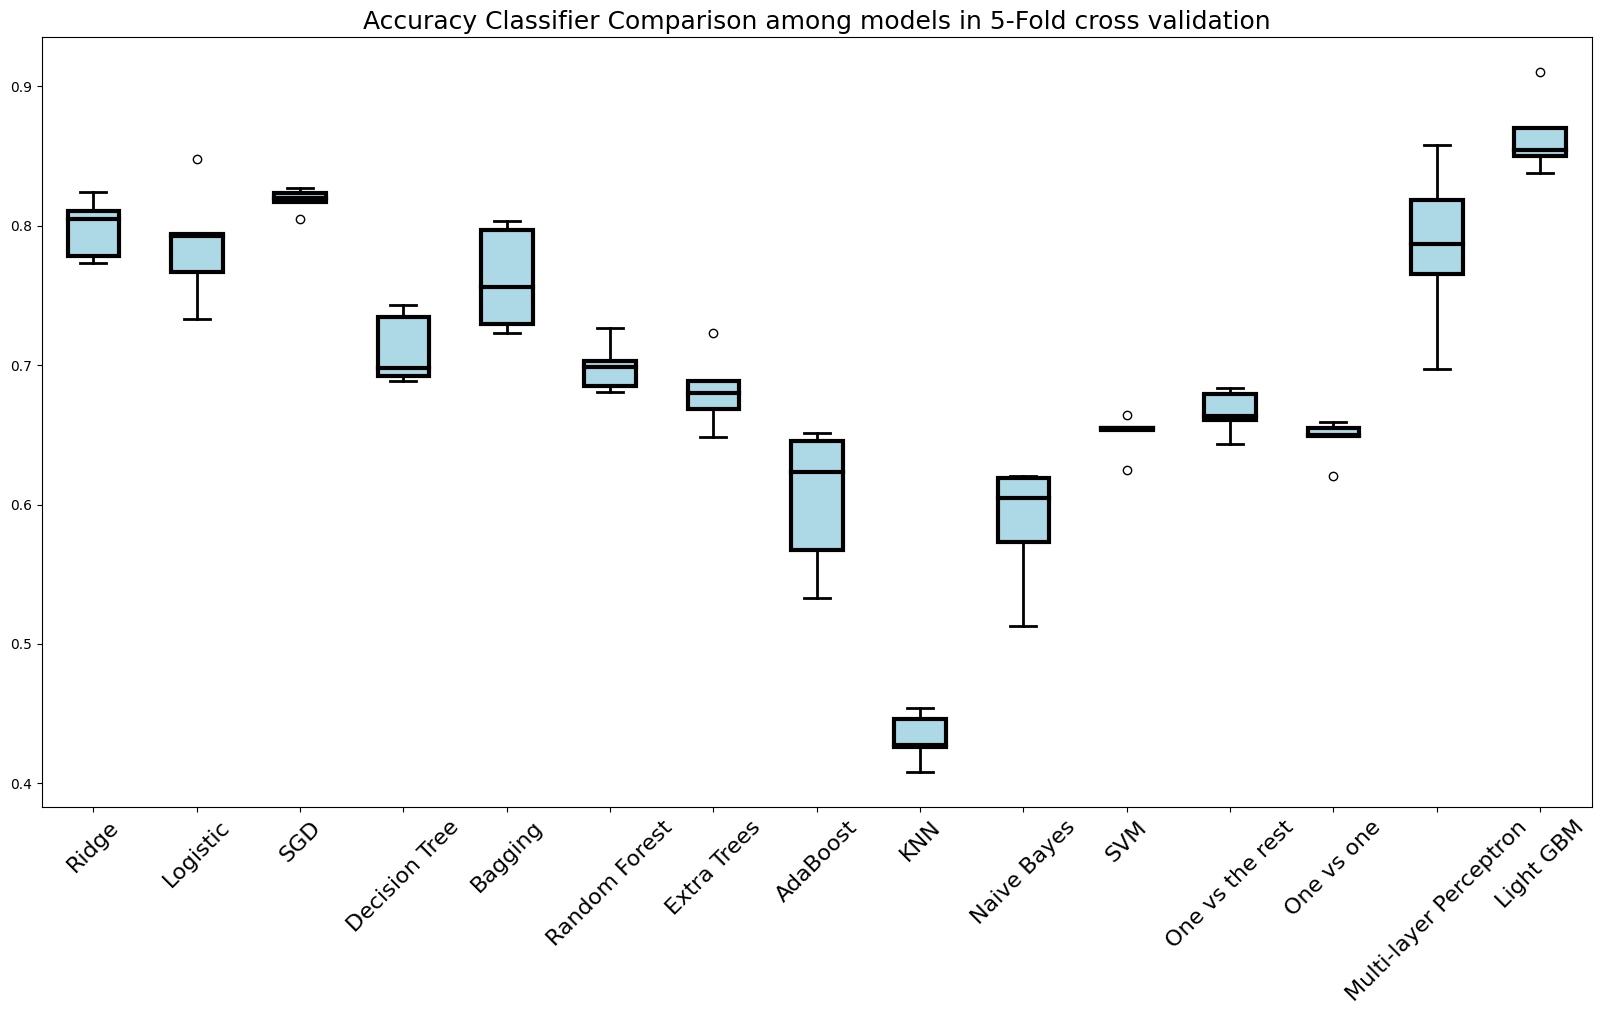

In [77]:
# Draw boxplot 
label = list(score_4k_dict.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_4k_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among scale models_4k in 5-Fold cross validation", fontsize=18)

Regarding the boxplots, we can see several models with scale data that have potential in classification: LGBM

## Top 500 genes

In [27]:
# select the top 4000 genes
ind_500 = highly_deviance_indices(X_train, num_genes=500)
X_500_train = X_bd_train[:, ind_500]
X_500_valid = X_bd_valid[:, ind_500]

In [29]:
models_500 = training(X_500_train, y_bd_train)

score_500_dict = dict()
for i, model in models_500:
    predictions = model.predict(X_500_valid)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, X_500_train, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_500_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  Ridge is:  0.8067078206880839
Cross Validation Score of  Ridge is :  0.6800688995574795
------------------------------------------------------------
Balanced score of  Logistic is:  0.8601475279106858
Cross Validation Score of  Logistic is :  0.8125902919845324
------------------------------------------------------------
Balanced score of  SGD is:  0.8427033492822967
Cross Validation Score of  SGD is :  0.8032092660444199
------------------------------------------------------------
Balanced score of  Decision Tree is:  0.5864768455228981
Cross Validation Score of  Decision Tree is :  0.7131590679257014
------------------------------------------------------------
Balanced score of  Bagging is:  0.699497322852586
Cross Validation Score of  Bagging is :  0.776986511867346
------------------------------------------------------------
Balanced score of  Random Forest is:  0.7450159489633175
Cross Validation Score of  Random Forest is :  0.7518694231951433
-----------------

Text(0.5, 1.0, 'Accuracy Classifier Comparison among models_500 in 5-Fold cross validation')

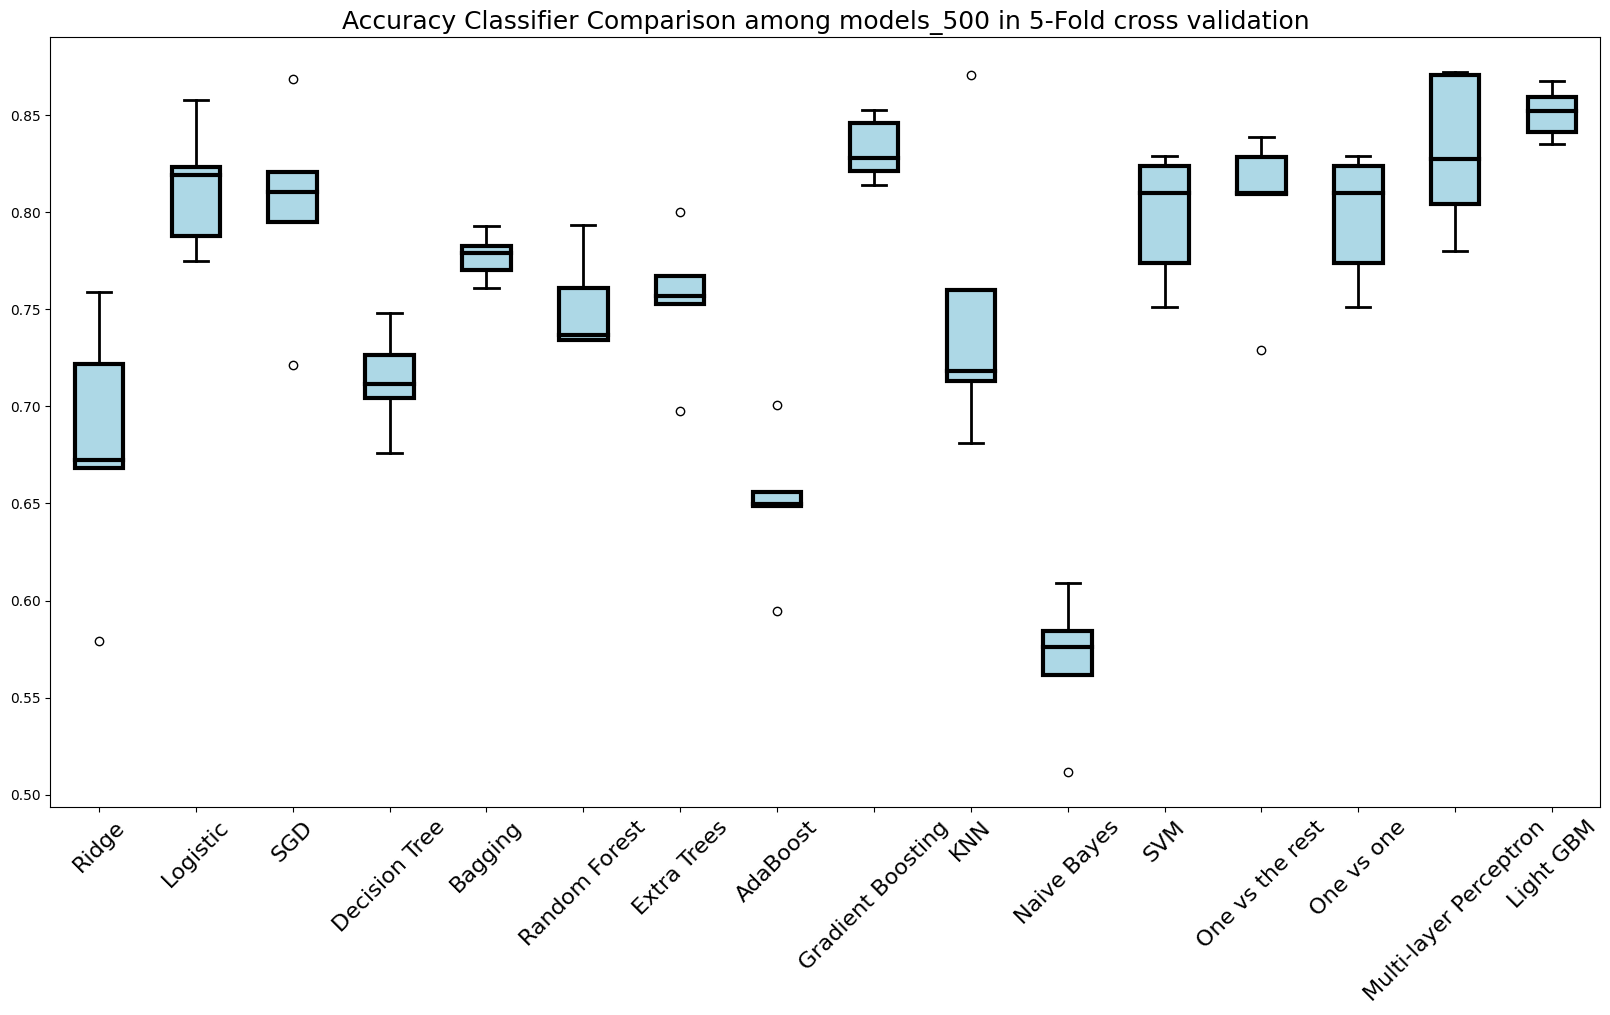

In [30]:
# Draw boxplot 
label = list(score_500_dict.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_500_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among models_500 in 5-Fold cross validation", fontsize=18)

Regarding the boxplots, we can see several models that have potential in classification: Logistic, SDG, SVM, OneVRest, OneVOne, MLP, LGBM, and Gradient Boosting

**With scale data**

In [87]:
X_500_train_scale = scaler.fit_transform(X_500_train)
X_500_valid_scale = scaler.fit_transform(X_500_valid)
models_500_scale = training(X_500_train_scale, y_bd_train)

score_500_dict_scale = dict()
for i, model in models_500_scale:
    predictions = model.predict(X_500_valid_scale)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, X_500_train_scale, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_500_dict_scale[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  Ridge is:  0.7990893426748691
Cross Validation Score of  Ridge is :  0.6293030461848734
------------------------------------------------------------
Balanced score of  Logistic is:  0.847488038277512
Cross Validation Score of  Logistic is :  0.8050014117044902
------------------------------------------------------------
Balanced score of  SGD is:  0.8280751594896332
Cross Validation Score of  SGD is :  0.7819273126373425
------------------------------------------------------------
Balanced score of  Decision Tree is:  0.5800937001594897
Cross Validation Score of  Decision Tree is :  0.7131590679257014
------------------------------------------------------------
Balanced score of  Bagging is:  0.706076270221007
Cross Validation Score of  Bagging is :  0.776986511867346
------------------------------------------------------------
Balanced score of  Random Forest is:  0.748305422647528
Cross Validation Score of  Random Forest is :  0.7518694231951433
-------------------

Text(0.5, 1.0, 'Accuracy Classifier Comparison among scale models_500 in 5-Fold cross validation')

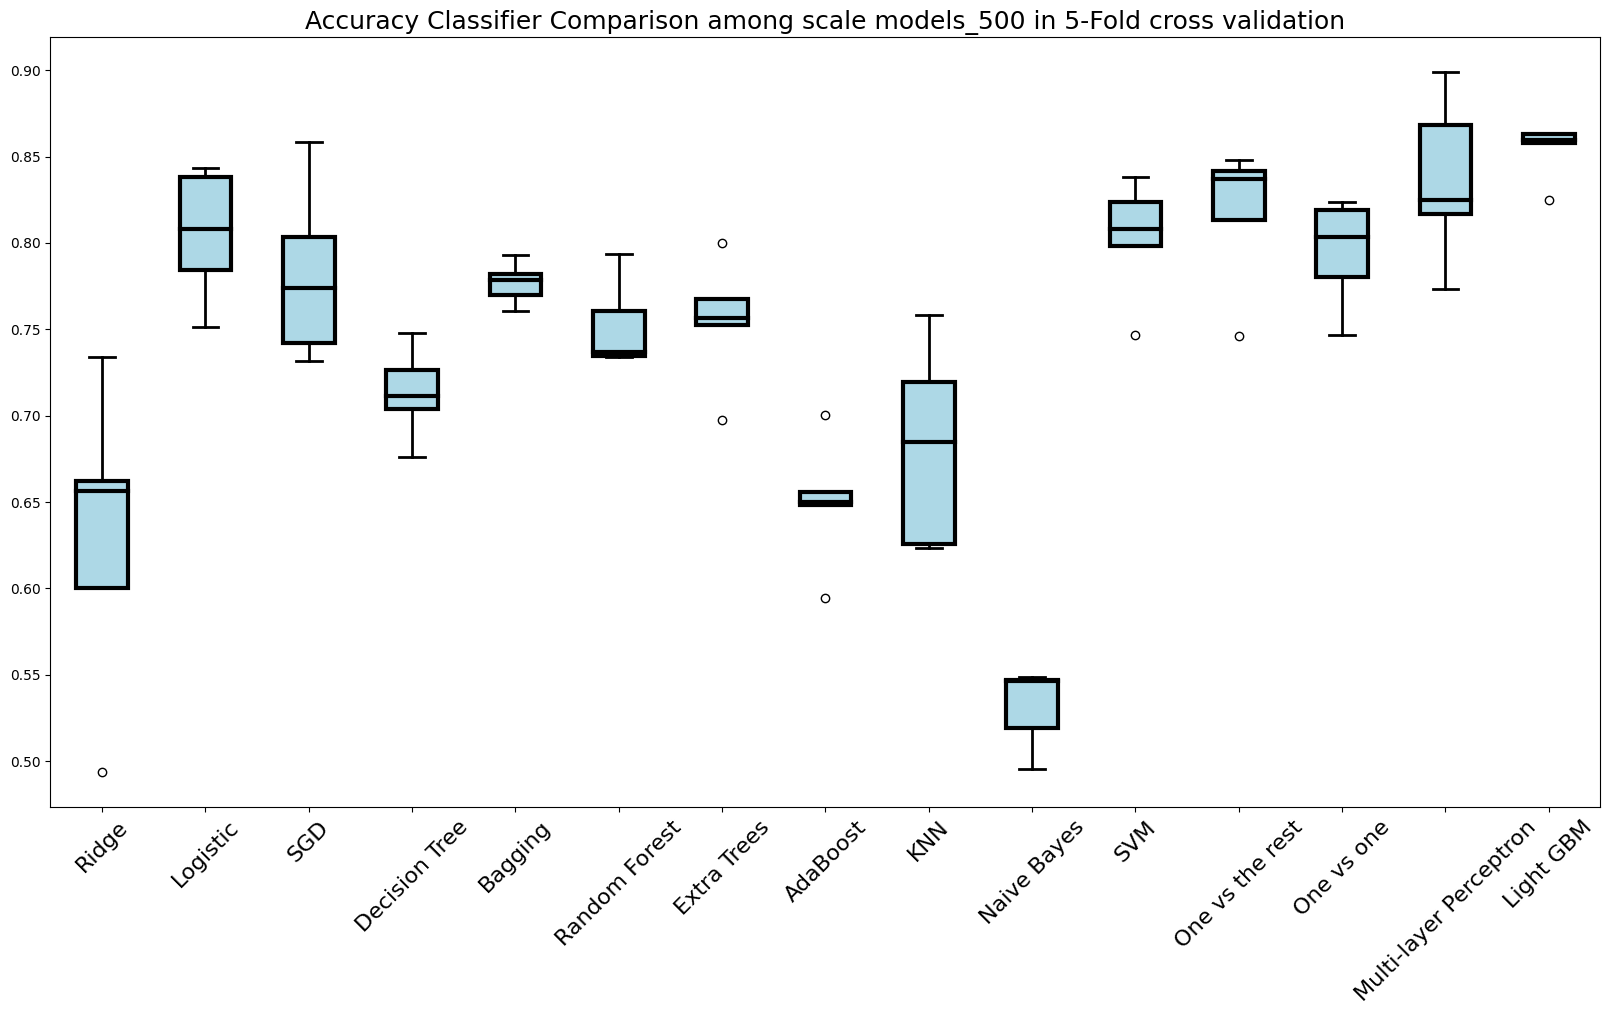

In [88]:
# Draw boxplot 
label = list(score_500_dict_scale.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_500_dict_scale.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among scale models_500 in 5-Fold cross validation", fontsize=18)

Regarding the boxplots, we can see several models with scale data that have potential in classification: Logistice, SVM, OneVRest, OneVOne, MLP

## **Stacking Classifier**

Now, we are going to select all the best stack models that we have been submitted on RAMP Studio for testing with the local data and making the confusion matrix

In [36]:
# RiverFlows2 with top 8000 genes: 0.89 on RAMP Studio, runtime: 4892.34
estimators_8k = [
            ('ridge', RidgeClassifier(random_state=42)),
            ('sgd', SGDClassifier(random_state=42)),
            ('mlp', make_pipeline(StandardScaler(), MLPClassifier(random_state=42))),
            ('xrf', ExtraTreesClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier()),
            ('lgbm', LGBMClassifier(learning_rate=0.5, verbose=-100, n_jobs=-1, random_state=42))
        ]

stack_8k = StackingClassifier(estimators=estimators_8k, final_estimator=make_pipeline(StandardScaler(), LogisticRegression()))
stack_8k.fit(X_8k_train, y_bd_train)

StackingClassifier(estimators=[('ridge', RidgeClassifier(random_state=42)),
                               ('sgd', SGDClassifier(random_state=42)),
                               ('mlp',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('mlpclassifier',
                                                 MLPClassifier(random_state=42))])),
                               ('xrf', ExtraTreesClassifier(random_state=42)),
                               ('gb', GradientBoostingClassifier()),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.5, n_jobs=-1,
                                               random_state=42,
                                               verbose=-100))],
                   final_estimator=Pipeline(steps=[('standardscaler',
                                                    StandardScaler()),
                                                   ('logisticregression',
                                                    LogisticRegression())]))

In [35]:
# balckbull_clf13 with top 4000 genes: 0.88 on RAMP Studio, runtime: 209.81
estimators_4k = [
            ('ridge', RidgeClassifier(random_state=42)),
            ('sgd', SGDClassifier(random_state=42)),
            ('mlp', make_pipeline(StandardScaler(),MLPClassifier(random_state=42))),
            ('lgbm', LGBMClassifier(learning_rate=0.5, verbose=-100, n_jobs=-1))
        ]

stack_4k = StackingClassifier(estimators=estimators_4k, 
                              final_estimator=make_pipeline(StandardScaler(),
                                                            LogisticRegression(C=0.7, penalty='l1', solver='saga', tol=1e-2)))
stack_4k.fit(X_4k_train, y_bd_train)

StackingClassifier(estimators=[('ridge', RidgeClassifier(random_state=42)),
                               ('sgd', SGDClassifier(random_state=42)),
                               ('mlp',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('mlpclassifier',
                                                 MLPClassifier(random_state=42))])),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.5, n_jobs=-1,
                                               verbose=-100))],
                   final_estimator=Pipeline(steps=[('standardscaler',
                                                    StandardScaler()),
                                                   ('logisticregression',
                                                    LogisticRegression(C=0.7,
                                                                       penalty='l1',
                                                                       solver='saga',
                                                                       tol=0.01))]))

**Stacking Classifier:** (Logistic)

In [37]:
models_stack = [
    ('stack 4k', stack_4k, X_4k_train, X_4k_valid),
    ('stack 8k', stack_8k, X_8k_train, X_8k_valid),
]

score_stack_dict = dict()
for i, model, x_train, x_valid in models_stack:
    predictions = model.predict(x_valid)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, x_train, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_stack_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  stack 4k is:  0.8728070175438597
Cross Validation Score of  stack 4k is :  0.8714196493491428
------------------------------------------------------------
Balanced score of  stack 8k is:  0.8851425438596492
Cross Validation Score of  stack 8k is :  0.8671069808855311
------------------------------------------------------------


In [55]:
list(score_stack_dict.keys())[0] 

'stack 4k'

Text(0.5, 1.0, 'Balanced Accuracy Classifier Comparison among stack models in 5-Fold cross validation the top 8000 and 4000')

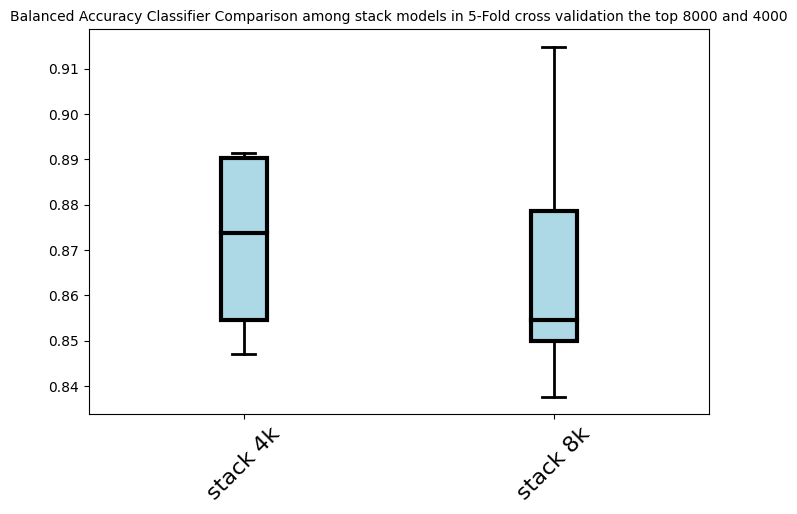

In [63]:
# Draw boxplot 
label = list(score_stack_dict.keys())
plt.figure(figsize=(8, 5))
bplot =plt.boxplot(list(score_stack_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Balanced Accuracy Classifier Comparison among stack models in 5-Fold cross validation the top 8000 and 4000", fontsize=10)

# **Testing data**

In [42]:
# Prediction on testing data
X_bd_test = preprocess_X(X_test.toarray(), quality_control=False)
X_8k_test = X_bd_test[:, ind_8k]
X_4k_test = X_bd_test[:, ind_4k]

<AxesSubplot: ylabel='Density'>

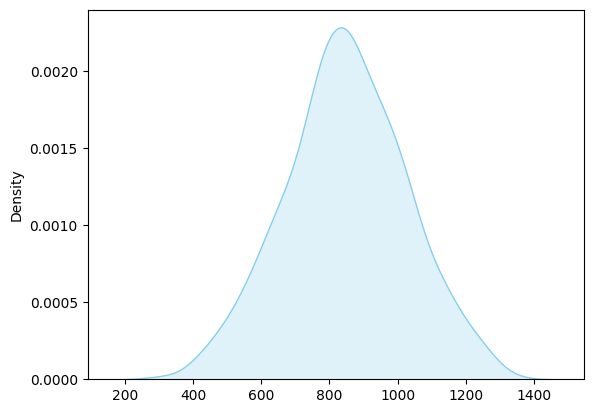

In [37]:
sns.kdeplot(X_bd_test.sum(axis=1), color='skyblue', fill=True)

In [2]:
# models_4k

In [43]:
best_models = [
    ('Stacking 8k', stack_8k, X_8k_test),
    ('Stacking 4k', stack_4k, X_4k_test),
]

In [44]:
y_pred = []
for i, model, X_test in best_models:
    predictions = model.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, predictions)
    y_pred.append(predictions)
    print('Accuracy of ', i , 'is: ',accuracy)
    print('--'*30)

Accuracy of  Stacking 8k is:  0.8578236543599176
------------------------------------------------------------
Accuracy of  Stacking 4k is:  0.8533854755796335
------------------------------------------------------------


In [45]:
ytr_8k_pred = stack_8k.predict(X_8k_train)
ytr_4k_pred = stack_4k.predict(X_4k_train)

Train balanced accuracy : 1.000
Test balanced accuracy : 0.858


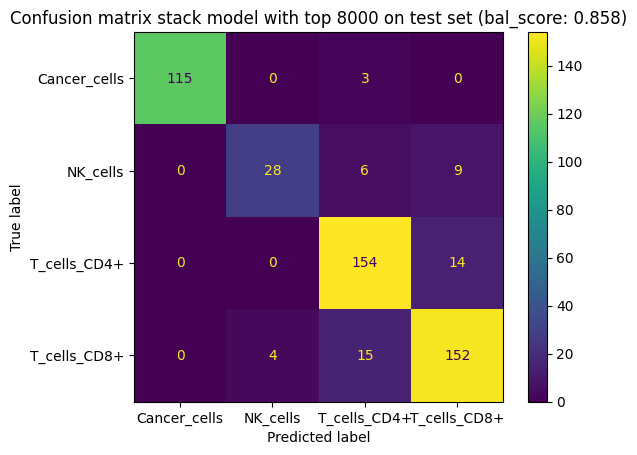

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_bd_train, ytr_8k_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_pred[0]):.3f}")
cm = confusion_matrix(y_test, y_pred[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack_8k.classes_, )
disp.plot()
plt.title("Confusion matrix stack model with top 8000 on test set (bal_score: 0.858)");

Train balanced accuracy : 1.000
Test balanced accuracy : 0.853


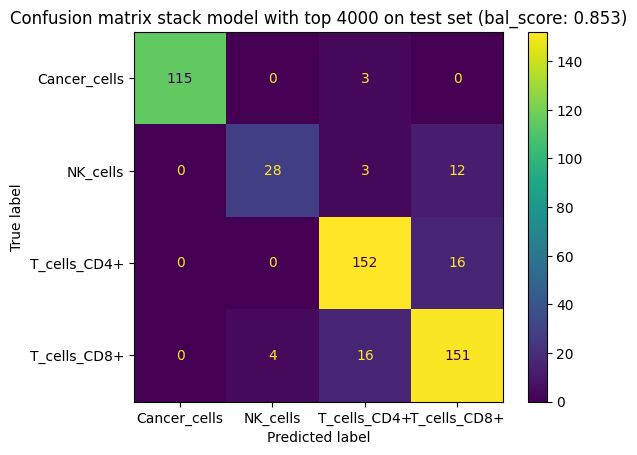

In [66]:
# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_bd_train, ytr_4k_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_pred[1]):.3f}")
cm = confusion_matrix(y_test, y_pred[1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack_4k.classes_, )
disp.plot()
plt.title("Confusion matrix stack model with top 4000 on test set (bal_score: 0.853)");

# GridSearchCV

In [101]:
# Function to do grid search 
def grid_cv(params_grid, model, X, y, k):
    grid_search = GridSearchCV(model, params_grid, scoring='balanced_accuracy', cv=k, n_jobs=-1, refit=True, verbose=1)
    grid_search.fit(X, y)

    best_params = grid_search.cv_results_['params'][grid_search.best_index_]
    best_score = grid_search.best_score_
    print('The best hyper-parameters are {0}, with accuracy = {1}.'.format(best_params, best_score))

In [61]:
dict_t = {
    "Default genes": X_bd_train.sum(axis=1),
    "Top genes 8000": X_8k_train.sum(axis=1),
    "Top genes 4000": X_4k_train.sum(axis=1),
    "Top genes 500": X_500_train.sum(axis=1)
}

Text(0.5, 1.0, 'Box plot of total count per genes')

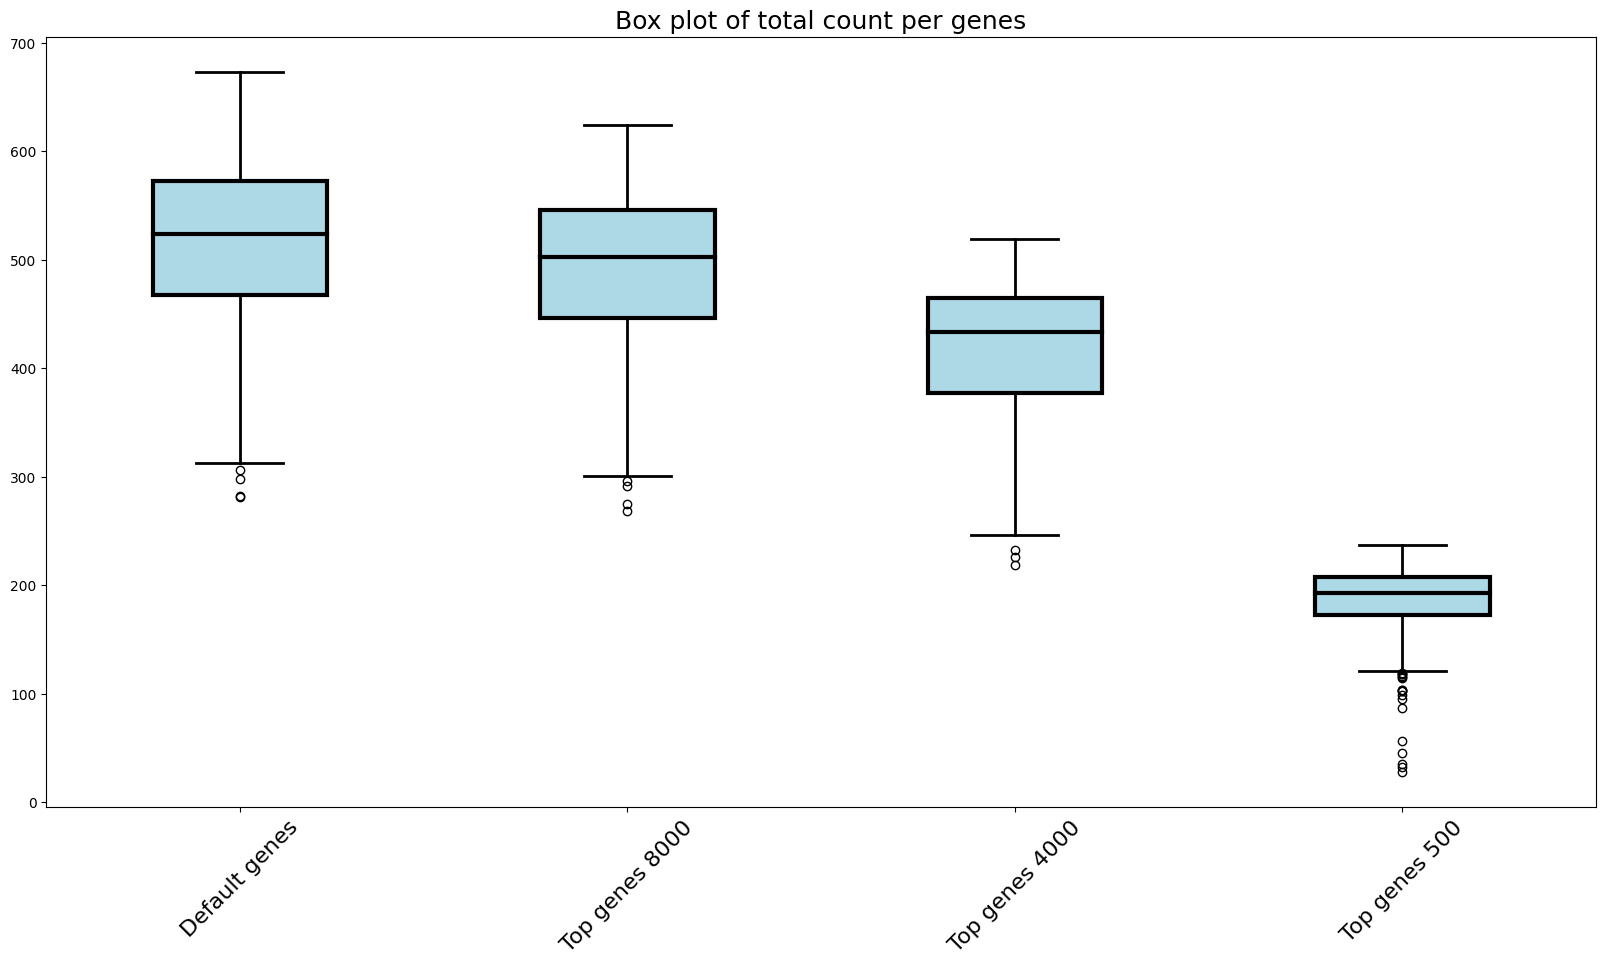

In [62]:
label = list(dict_t.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(dict_t.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Box plot of total count per genes", fontsize=18)